In [1]:
import numpy as np
import torch
import torch.nn as nn
import sys

sys.path.append("../../")
from vi_rnn.vae import VAE
from vi_rnn.train import train_VAE
from torch.utils.data import DataLoader
from vi_rnn.datasets import RDM, RDM_Teacher
from py_rnn.model import RNN, predict
from py_rnn.train import train_rnn
from py_rnn.train import save_rnn, load_rnn
from vi_rnn.utils import *
import matplotlib.pyplot as plt
from vi_rnn.saving import save_model, load_model
from py_rnn.default_params import get_default_params

%matplotlib inline

In [2]:
train_teacher = False  # load already trained teacher model
data_dir = "../../data/student_teacher/"  # store inferred model
model_dir = "../../models/students/"  # store teacher RNN
cuda = True  # toggle if GPU is available

In [3]:
# initialise teacher RNN
model_params, training_params = get_default_params(n_rec=60)
training_params["n_epochs"] = 1000
training_params["l2_rates_reg"] = 0.1
model_params["rank"] = 1
rnn_reach = RNN(model_params)

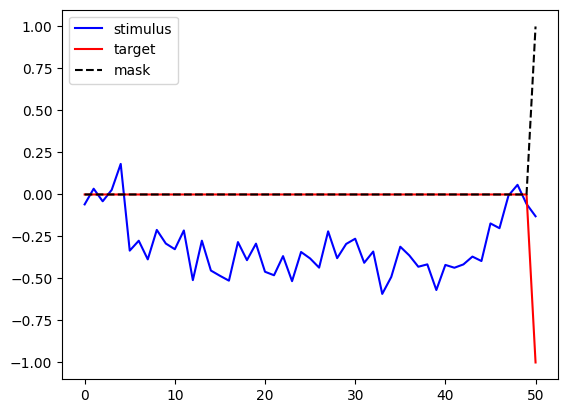

In [4]:
# Plot an example trial for teacher RNN

task_params_teacher = {
    "name": "rdm",
    "fixation_dur": 5,
    "stimulus_dur": 40,
    "delay_dur": 5,
    "response_dur": 1,
    "std": 0.1,
    "scale": 0.1,
}
rdm = RDM(task_params_teacher)
stimulus, targets, mask = rdm.__getitem__(0)
plt.plot(stimulus, c="b", label="stimulus")
plt.plot(targets, c="r", label="target")
plt.plot(mask, ls="--", c="k", label="mask")
plt.legend()

In [5]:
# train or load teacher RNN
if train_teacher:
    losses, reg_losses = train_rnn(rnn_reach, training_params, rdm, sync_wandb=False)
    save_rnn(
        data_dir + "rdm_rnn2",
        rnn_reach,
        model_params,
        task_params_teacher,
        training_params,
    )
else:
    rnn_reach, model_params, task_params_teacher, training_params = load_rnn(
        data_dir + "rdm_rnn"
    )

In [6]:
# Increase response duration -> makes it easier for student to learn fixed points
task_params_teacher["response_dur"] = 50

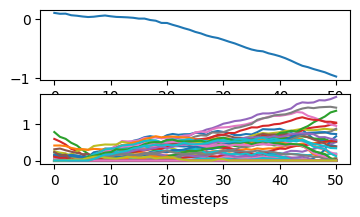

In [7]:
# plot example output
inp = []
for i in range(6):
    stim, _, _ = rdm[i]
    inp.append(stim)
inp = torch.stack(inp)
rates, pred = predict(rnn_reach, inp)
fig, axs = plt.subplots(2, figsize=(4, 2))
axs[0].plot(pred[0, :, :])
axs[1].set_xlabel("timesteps")
axs[1].plot(rnn_reach.rnn.nonlinearity(torch.from_numpy(rates[0])));

In [8]:
# Extract weights
U, V, B = extract_orth_basis_rnn(rnn_reach)
I = rnn_reach.rnn.w_inp.detach()

In [9]:
# Generate data using teacher RNN, used for training student RNN
batch_size = 4
task_params = {
    "name": "rdm",
    "n_neurons": rnn_reach.rnn.N,
    "out": "currents",
    "r0": 0,
    "R_x": 0.1,
    "R_z": 0.05,
    "n_trials": 400,
    "sim_v": True,
}
task = RDM_Teacher(task_params, task_params_teacher, U, V, B, I, decay=0.9)
data_loader = DataLoader(task, batch_size=batch_size, shuffle=True)

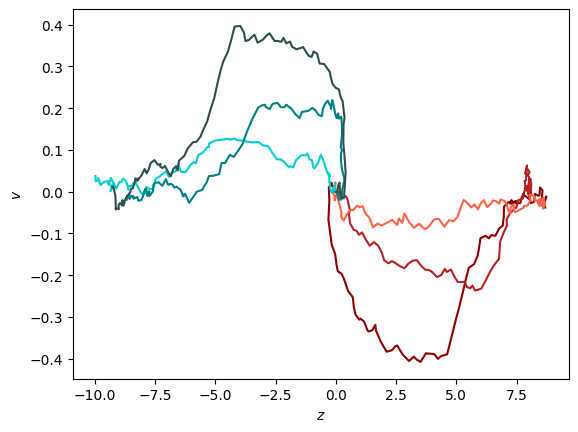

In [10]:
# Plot example latents of teacher RNN
colors = ["darkred", "firebrick", "tomato", "darkturquoise", "teal", "darkslategrey"]
for tr_i in range(6):
    latent_code = task.latents[tr_i]
    v = task.v[tr_i]
    stim = task.stim[tr_i]
    plt.plot(latent_code[0], v[0], color=colors[tr_i % 6])
    plt.xlabel(r"$z$")
    plt.ylabel(r"$v$")

In [11]:
# Initialise VI / student setup

dim_z = 1
dim_N = task_params["n_neurons"]
dim_x = task_params["n_neurons"]
dim_u = 1
bs = 10
cuda = True
n_epochs = 500
wandb = False
# initialise encoder
enc_params = {}

# initialise prior
prior_params = {
    "train_noise_x": True,
    "train_noise_z": True,
    "train_noise_z_t0": True,
    "init_noise_z": 0.1,
    "init_noise_z_t0": 1,
    "init_noise_x": task_params["R_x"],
    "noise_z": "full",
    "noise_x": "diag",
    "noise_z_t0": "full",
    "observation": "one_to_one",
    "transition": "low_rank",
    "activation": "relu",
    "decay": 0.7,
    "readout_from": task_params["out"],
    "train_obs_bias": False,
    "train_obs_weights": False,
    "train_neuron_bias": True,
    "weight_dist": "uniform",
    "weight_scaler": 1,  # /dim_N,
    "initial_state": "trainable",
    "obs_nonlinearity": "identity",
    "obs_likelihood": "Gauss",
    "simulate_input": True
}


training_params = {
    "lr": 1e-3,
    "lr_end": 1e-5,
    "n_epochs": n_epochs,
    "grad_norm": 0,
    "eval_epochs": 50,
    "batch_size": bs,
    "cuda": cuda,
    "smoothing": 20,
    "freq_cut_off": 10000,
    "k": 64,
    "loss_f": "opt_smc",
    "resample": "systematic",  # , multinomial or none"
    "run_eval": True,
    "smooth_at_eval": False,
    "init_state_eval": "posterior_sample"
}


VAE_params = {
    "dim_x": dim_x,
    "dim_z": dim_z,
    "dim_u": dim_u,
    "dim_N": dim_N,
    "enc_params": enc_params,
    "rnn_params": prior_params,
}
vae = VAE(VAE_params)

using uniform init
Initialising VAE without encoder


In [12]:
import torch

In [13]:
v = torch.zeros(3, 1, 4, 1)
z = torch.zeros(3, 10, 4, 10)
torch.concat([(v.repeat(*([1] * len(v.shape[:-1])), z.shape[-1])), z], dim=1).shape

torch.Size([3, 11, 4, 10])

In [ ]:
# Train

train_VAE(
    vae,
    training_params,
    task,
    sync_wandb=wandb,
    out_dir=model_dir,
    fname=None,
    store_train_stats=False,
)

Training on : cuda
Learning rate decay factor 0.9908319448927676
n outliers: 0.0020000000000000018
KL_x = 16.811, PS_dist = 0.445, Mean_rate_error = 170.086
epoch 1  ll: -1335.9209,alpha: 0.95, lr: 0.001000
epoch 2  ll: -1286.1967,alpha: 0.95, lr: 0.000991
epoch 3  ll: -1272.9835,alpha: 0.95, lr: 0.000982
epoch 4  ll: -1256.3523,alpha: 0.95, lr: 0.000973
epoch 5  ll: -1236.6763,alpha: 0.95, lr: 0.000964
epoch 6  ll: -1214.1013,alpha: 0.94, lr: 0.000955
epoch 7  ll: -1188.7296,alpha: 0.94, lr: 0.000946
epoch 8  ll: -1160.5041,alpha: 0.94, lr: 0.000938
epoch 9  ll: -1129.5488,alpha: 0.94, lr: 0.000929
epoch 10  ll: -1095.7559,alpha: 0.94, lr: 0.000920
epoch 11  ll: -1059.4845,alpha: 0.93, lr: 0.000912
epoch 12  ll: -1020.8134,alpha: 0.93, lr: 0.000904
epoch 13  ll: -980.3254,alpha: 0.93, lr: 0.000895
epoch 14  ll: -938.1389,alpha: 0.93, lr: 0.000887
epoch 15  ll: -894.9106,alpha: 0.93, lr: 0.000879
epoch 16  ll: -851.0756,alpha: 0.92, lr: 0.000871
epoch 17  ll: -807.3103,alpha: 0.92, lr:

In [ ]:
save_model(vae, training_params, task_params, name=model_dir + "rdm_student2")